In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
import torch
# import skgstat as skg
import torch.nn as nn
# import geopandas as gpd 
import plotly.express as px
import torch.nn.functional as F
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
import matplotlib.pyplot as plt
# plt.style.use('ggplot')

from sklearn.metrics import r2_score
import seaborn as sns

plt.rcParams['figure.figsize'] = (6,5)

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [28]:
data = pd.read_csv("Dataset/CleanedOC.csv")

In [29]:
data.head()

,lat,lon,OC
0,17.894722,73.401111,0.611429
1,17.894722,73.401389,0.634286
2,17.894722,73.402222,0.382857
3,17.894722,73.403056,1.000000
4,17.894722,73.403889,0.794286


In [30]:
data.corr()

,lat,lon,OC
lat,1.000000,0.174989,-0.100815
lon,0.174989,1.000000,-0.046780
OC,-0.100815,-0.046780,1.000000


## Data PreProcessing

In [31]:
#drop duplicates rows
data.drop_duplicates(subset=['lat', 'lon'], inplace = True)
data = data.reset_index(drop = True)
data.head()

,lat,lon,OC
0,17.894722,73.401111,0.611429
1,17.894722,73.401389,0.634286
2,17.894722,73.402222,0.382857
3,17.894722,73.403056,1.000000
4,17.894722,73.403889,0.794286


In [32]:
data.shape

(25893, 3)

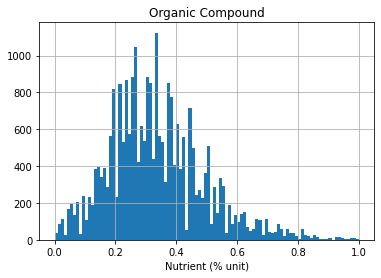

In [33]:
#visually check the distribution of data
data['OC'].hist(bins = 100)
plt.title("Organic Compound")
plt.xlabel("Nutrient (% unit)")
plt.show()
plt.show()

<AxesSubplot:xlabel='OC'>

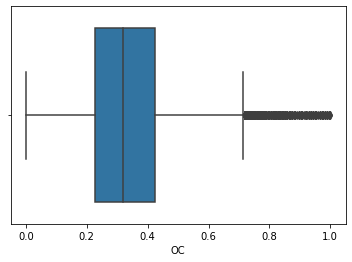

In [34]:
#create a boxplot to see whether there are outliers in the data or not.
sns.boxplot('OC',data = data)

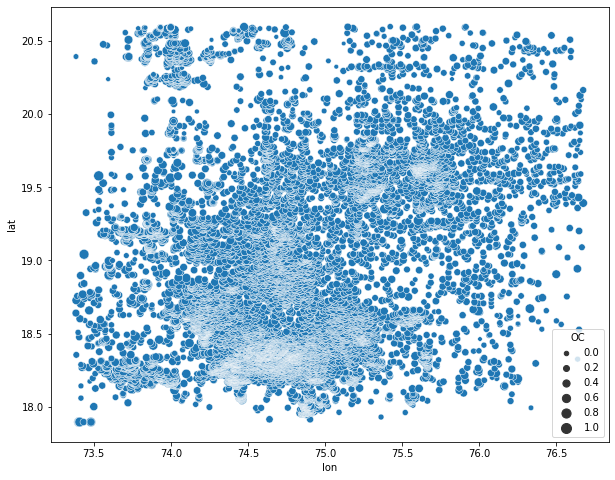

In [35]:
# scatetr plot to see the spatial distribution of the data
plt.figure(figsize=(10, 8))
sns.scatterplot(x ='lon', y ='lat',size ='OC',sizes =(20, 100), data = data)
plt.show()

In [36]:
## Desnity plot
fig = px.density_mapbox(data, lat='lat', lon='lon', z='OC', radius=8,
                         zoom=7,
                        mapbox_style="stamen-terrain", height=800)
fig.show()

### Split the data (80/20)

In [37]:
# split the data
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.25, random_state=0, shuffle = True)
test, val = train_test_split(test, test_size=0.20, random_state=0, shuffle=True)
print(f"Train shape: {train.shape}\nTest shape: {test.shape}\nValidation shape:{val.shape}")

Train shape: (19419, 3)
Test shape: (5179, 3)
Validation shape:(1295, 3)


In [38]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
# train.head()

## Krigging

**Assumptions for Ordianry Krigging:**
1. Isotropy -  spatial data only depends on the distance separating them.
2. Spatial autocorrelation
3. Stationarity -  mean and variance is constant across the spatial field.

**Auto-correlation**\
Spatial auto-correaltion helps us to establish a relationship between neighbouring data. \
 We will use *morans'I* test to estimate the spatial autocorrelation. 



In [39]:
from geopandas import GeoDataFrame
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(train.lon, train.lat)]
df = train.copy().drop(['lon', 'lat'], axis=1)
gdf_ = GeoDataFrame(df, crs="EPSG:7767", geometry=geometry)
gdf_.head()

,OC,geometry
0,0.388571,POINT (75.663 18.291)
1,0.234286,POINT (75.270 19.480)
2,0.337143,POINT (75.218 19.423)
3,0.234286,POINT (74.625 18.375)
4,0.171429,POINT (74.568 18.419)


In [40]:
# Moran's I test for global spatial autocorrelation
# Hypothesis:
# Null :  There is no global spatial autocorrelation
# Alternate :  There is spatial autocorrelation present among the datapoints
from libpysal.weights.contiguity import Queen
from esda.moran import Moran
from splot.esda import moran_scatterplot

# queen continuity based spatial weights
y = gdf_['OC'].values

w = Queen.from_dataframe(gdf_)
moran = Moran(y, w)

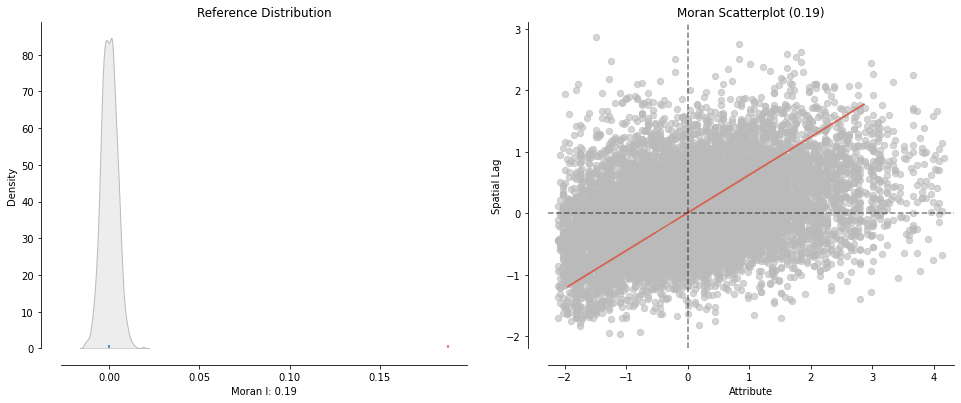

In [41]:
from splot.esda import plot_moran

#visulaize global autocorrelation statistics
plot_moran(moran, zstandard=True, figsize=(16,6))
plt.show()

In [42]:
# let's check for  statistics and p value
stats_, pval_ = moran.I, moran.p_sim
print(f"statstics: {stats_}\np value: {pval_}")

statstics: 0.18827175712727331
p value: 0.001


**Decision:** Since pval is less than than `0.05` (with 95% confidence), we rehect the null hypothesis. There fore autocorrelation exist.

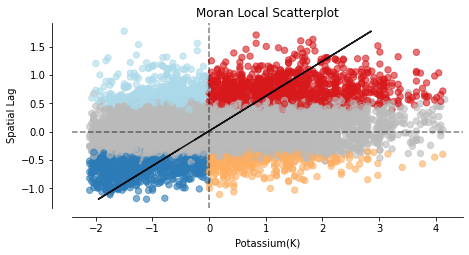

In [43]:
# visualize the local autocorrelation
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local

# calculate Moran_Local and plot
moran_loc = Moran_Local(y, w)
fig, ax = moran_scatterplot(moran_loc, p=0.05)
ax.set_xlabel('Potassium(K)')
ax.set_ylabel('Spatial Lag')
plt.show()

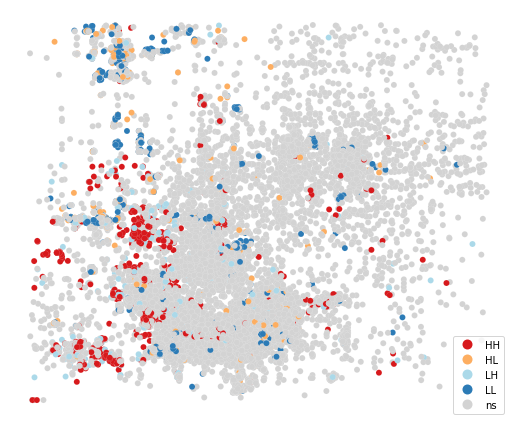

In [44]:
# show the significantly correlated area on the map
from splot.esda import lisa_cluster

lisa_cluster(moran_loc, gdf_, p=0.05, figsize = (9,9))
plt.show()

In the above plot, red dots are corresponding to high autocorrelation of similarity.

#### Stationarity

In [45]:
from skgstat import Variogram, OrdinaryKriging

In [46]:
%%time
#estimate variogram
data_ = train.copy()
lat, lon = data_['lat'].to_numpy(), data_['lon'].to_numpy()
cordinates = np.asarray([(lat[i], lon[i]) for i in range(len(lat))])
variogram = Variogram(cordinates, data_['OC'].values,
                          n_lags = 25,
                          maxlag=0.5,
                          model = 'spherical',
                          bin_func='even',
                          use_nugget=True,
                          verbose = True)

CPU times: user 50.2 s, sys: 33.4 s, total: 1min 23s
Wall time: 1min 34s


plotting...


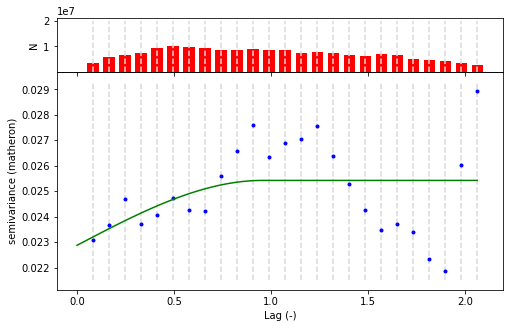

In [47]:
variogram.plot(show = False)
print("plotting...")

In [48]:
# Since the variogram
range_, sill, nugget = variogram.parameters
print(f"Range: {range_}\nsill: {sill}\nnugget: {nugget}")

Range: 0.9561123890129297
sill: 0.002550719924746488
nugget: 0.02287158764883147


since the variogram is bounded(sill defined), therefore no trend is there is the data, so we can that there is stationarity in the data.

In [49]:
data.lat.min(), data.lat.max()

(17.89472222, 20.59805556)

In [50]:
data.lon.min(), data.lon.max()

(73.38416667, 76.67527778)

In [51]:
from skgstat import  OrdinaryKriging

In [52]:
## Ordiinary kriging
ok = OrdinaryKriging(variogram, min_points=1, max_points=15, mode='exact')

In [53]:
xx, yy = np.mgrid[17:21:500j, 73:77:500j]
field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)

In [62]:
def interpolate(V, model, field):
#     xx, yy = np.mgrid[18:21:500j, 73:77:500j]
#     field = model.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
    plt.pcolormesh(xx, yy, field, vmin = 0, vmax=1, cmap='viridis_r')
    plt.title('%s model' % V.model.__name__)
    plt.colorbar()
    return field

In [66]:
field.shape

(500, 500)

CPU times: user 59.3 ms, sys: 21.8 ms, total: 81.1 ms
Wall time: 110 ms


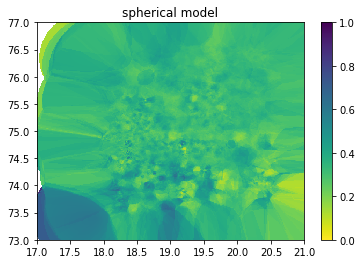

In [63]:
%%time
field = interpolate(variogram, ok, field)

In [56]:
with open("OC_krig_interpolation.npy", "wb") as f:
    np.save(f, field)

In [57]:
%%time
# R2 value
field_pred = ok.transform(test.lat.values, test.lon.values)

CPU times: user 18.6 s, sys: 1min 12s, total: 1min 30s
Wall time: 20.2 s


In [58]:
r2 = r2_score(test.OC.values, field_pred)
r2

0.14073615836963038

In [59]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [60]:
mae = mean_absolute_error(test.OC.values, field_pred)
mae

0.11072560676485334

In [64]:
mse = mean_squared_error(test.OC.values, field_pred)
mse**0.5

0.1438066348385822